### 1. Loading data set and the required libraries


In [51]:
### 1. Loading the libraries and required libraries 
# Importing ML libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
sns.set()

1. `scipy.cluster.hierarchy.linkage:` This function is used to perform hierarchical clustering by calculating the linkage matrix that represents the distances between data points in a hierarchical structure. It takes the input data and a method argument that specifies the type of linkage to be used, such as 'ward', 'complete', 'average', etc. The linkage matrix is used to create a dendrogram, which is a visual representation of the hierarchical clustering.

2. `scipy.cluster.hierarchy.dendrogram:` This function is used to plot the dendrogram, which is a tree-like diagram that shows the hierarchical structure of the clusters. It takes the output from the linkage function as input and can be customized with various arguments, such as leaf_rotation and leaf_font_size, to control the appearance of the dendrogram.

3. `sns.set():` This function is used to set the default style for plotting with Seaborn, which is a popular data visualization library in Python. It can be used to customize the appearance of plots, such as setting color palettes, fonts, and styles.

In [52]:
# Loading the Instacart datasets into pandas dataframes
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
instacart_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Machine Learning Algo/3. Clustering/K-means clustering/instacart.csv', dtype={'product_name':'object', 
                                                               'aisle_id':'int16',
                                                               'department_id':'int16',
                                                               'num_orders':'int32',
                                                               'num_reordered':'int64',
                                                               'reorder_rate':'float32',
                                                               'add_to_cart_mean':'float32',
                                                               'order_mean_dow':'float32', 
                                                               'order_mean_hour_of_day':'float32', #could also be category
                                                               'mean_day_gap_in_orders':'float32'})


In [54]:
#Let's explore the data and the associated columns.
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.120001
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.270000
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.080000
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218488,16.059999
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538461,14.692307,13.540000


In [55]:
#Checking for null values
instacart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13377 entries, 0 to 13376
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_name            13377 non-null  object 
 1   aisle_id                13377 non-null  int16  
 2   department_id           13377 non-null  int16  
 3   num_orders              13377 non-null  int32  
 4   num_reordered           13377 non-null  int64  
 5   reorder_rate            13377 non-null  float32
 6   add_to_cart_mean        13377 non-null  float32
 7   order_mean_dow          13377 non-null  float32
 8   order_mean_hour_of_day  13377 non-null  float32
 9   mean_day_gap_in_orders  13377 non-null  float32
dtypes: float32(5), int16(2), int32(1), int64(1), object(1)
memory usage: 574.9+ KB


In [56]:
# Aisle and department are categorical variables. Let us check the numbers of categories they have
instacart_df['aisle_id'].nunique(), instacart_df['department_id'].nunique()

(134, 21)

aisle_id column has 134 categories, and the department_id column has 21. When forming clusters, categorical variables with a low number of values could help the algorithm deliver better results by adding another dimension. But since, in this case, the number of categories is high, it won't add value to the clustering quality by the algorithm.

Let's see how the Python sees these data points:

In [57]:
#Using the describe function to check data distribution of the dataset
instacart_df.describe()

,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders
count,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000
mean,70.670255,11.396651,96.935113,59.192794,0.514981,9.283619,2.762032,13.604996,17.284019
std,38.380694,6.267054,372.921094,290.603486,0.175570,2.232181,0.444830,0.865992,2.429661
min,1.000000,1.000000,11.000000,0.000000,0.000000,2.125000,0.636364,8.714286,6.363000
25%,37.000000,6.000000,17.000000,8.000000,0.400000,7.900000,2.500000,13.125000,15.810000
50%,77.000000,13.000000,31.000000,15.000000,0.533333,9.327868,2.745763,13.591837,17.219999
75%,106.000000,16.000000,72.000000,39.000000,0.642857,10.646153,3.000000,14.086957,18.750000
max,134.000000,21.000000,18726.000000,16557.000000,1.000000,19.590910,5.000000,17.562500,29.230000


Some of the interesting insights from the data distribution pattern are as follows: 

*   order_mean_dow indicates that the initial days of the week have low traction.
*   order_mean_hour_of_day shows that the majority of orders start coming in post noon.




### 2. Preparing the data for Clustering

1.  Dropping irrelevant columns

In [58]:
#Let us first drop unnecessary columns for our use case.
temp = instacart_df[instacart_df.columns.difference(['product_name', 'department_id', 'aisle_id'])]
#These columns are dropped as these features are irrelevant to our use case.

In [59]:
#Let us now look at the updated dataset.
temp.head()

,add_to_cart_mean,mean_day_gap_in_orders,num_orders,num_reordered,order_mean_dow,order_mean_hour_of_day,reorder_rate
0,6.921052,17.120001,76,49,3.026316,12.960526,0.644737
1,8.954545,17.270000,22,14,2.727273,15.272727,0.636364
2,9.846154,15.080000,13,7,4.538462,13.461538,0.538462
3,8.285714,16.059999,119,70,2.865546,14.218488,0.588235
4,10.615385,13.540000,13,6,3.538461,14.692307,0.461538


2.  ####   Scaling with StandardScaler 

As we learned before, scaling is essential for clustering algorithms. We'll be using *standardization* as the scaling method in this demo.

In [60]:
#Scaling the values using the sklearn standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()         
temp_scaled = scaler.fit_transform(temp)


In [61]:
#Let us now print the values after standardization.
temp_scaled[:5]

array([[-1.05845095, -0.06750906, -0.05614028, -0.03507589,  0.59414367,
        -0.74422618,  0.73908156],
       [-0.14742791, -0.0057699 , -0.20094844, -0.15551941, -0.0781442 ,
         1.92587649,  0.69138824],
       [ 0.25202106, -0.90716411, -0.22508314, -0.17960812,  3.99364684,
        -0.16566344,  0.13374316],
       [-0.44707019, -0.50380078,  0.05916992,  0.03719023,  0.23271277,
         0.70845307,  0.41725189],
       [ 0.59664343, -1.54102106, -0.22508314, -0.18304936,  1.74551472,
         1.25561466, -0.30440686]])

### 3. Building Clustering Models - Part I

####1.   K-Means Clustering:

  * Step 1: Find the optimal number of clusters

---





*   Finding the Optimal Number of Clusters
  1.   WCSS Method -  in this method, we identify an elbow by plotting the sum of squared distances from each point to its cluster center (centroid).



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

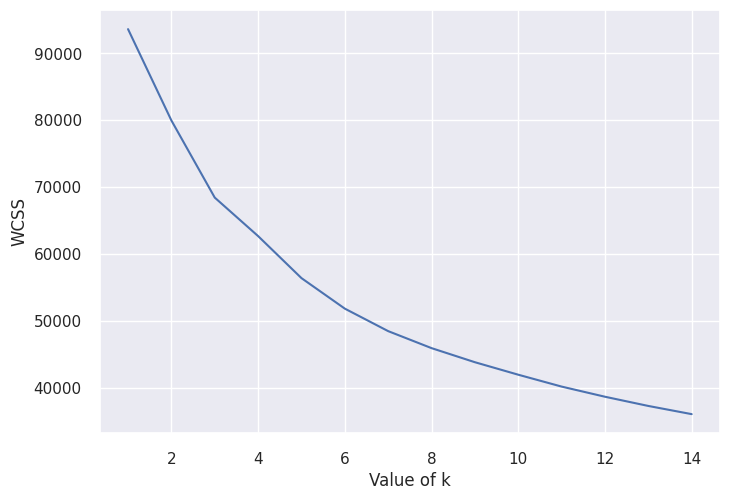

In [62]:
# elbow-curve/WCSS
ssd = []
range_n_clusters = range(1, 15)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state=0)
    kmeans.fit(temp_scaled)
    
    ssd.append(kmeans.inertia_)
    
# Plot the SSDs for each n_clusters
plt.plot(range_n_clusters, ssd)
plt.xlabel("Value of k")
plt.ylabel("WCSS")
plt.show()

calculates the WCSS for different values of k (ranging from 1 to 14) using the K-means algorithm, and stores the WCSS values in a list ssd. Then, it plots the WCSS values against the corresponding k values using Matplotlib

Considering the plot above for WCSS vs. K values, determining the elbow point is not easy or obvious.

Let's now try the Silhouette Analysis method to find the optimal value of K.

*   Finding the Optimal Number of Clusters
  2.   Silhouette Analysis Method

The Silhouette coefficient score for a data point is computed using the below formula:
$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the data point's cluster points.

* The value of the Silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in its cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

The below code calculates the Silhouette score for different values of k (ranging from 2 to 14) using the K-means algorithm. The Silhouette score is a measure of the quality of clustering, where higher values indicate better clustering results.

In the code, kmeans.labels_ gives the cluster labels for each data point obtained from the K-means algorithm. The silhouette_score function from the sklearn.metrics module is then used to calculate the Silhouette score for each value of k by passing the scaled data (temp_scaled) and the cluster labels to the function.


By printing temp1, you can see the Silhouette scores for each value of k. You can use this information to identify the optimal number of clusters that maximizes the Silhouette score, indicating better clustering results for your data.

In [63]:
# Silhouette score analysis
temp1 = []
range_n_clusters = range(2, 15)
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=0)
    kmeans.fit(temp_scaled)
   
    temp1.append(silhouette_score(temp_scaled, kmeans.labels_))
print(temp1)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

[0.8057103833679096, 0.1562771808987962, 0.13592384675085306, 0.13937343218969492, 0.13727966165369135, 0.1377586062522358, 0.13081776520646732, 0.1325742481471285, 0.12622218191100673, 0.12635588295064293, 0.1237393047795103, 0.12812518800640824, 0.12218092285186632]


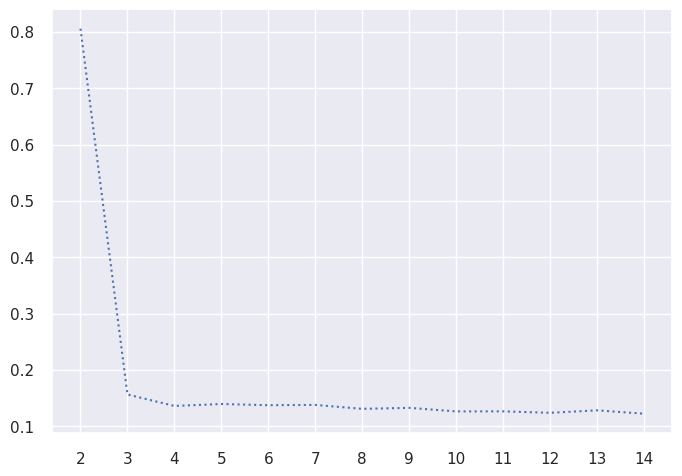

In [64]:
#Visualizing variation in the Silhouette score
plt.plot(temp1, linestyle = 'dotted')
default_x_ticks = range(len(range_n_clusters))
plt.xticks(default_x_ticks, range_n_clusters)
plt.show()

Silhouette score quickly drops at K=3 and stabilizes around K = 5.

Let us visualize the Silhouette scores with SilhoetteVisualizer to better understand the distribution of Silhouette scores for different values of K in the neighborhood of the elbow point value of 3.

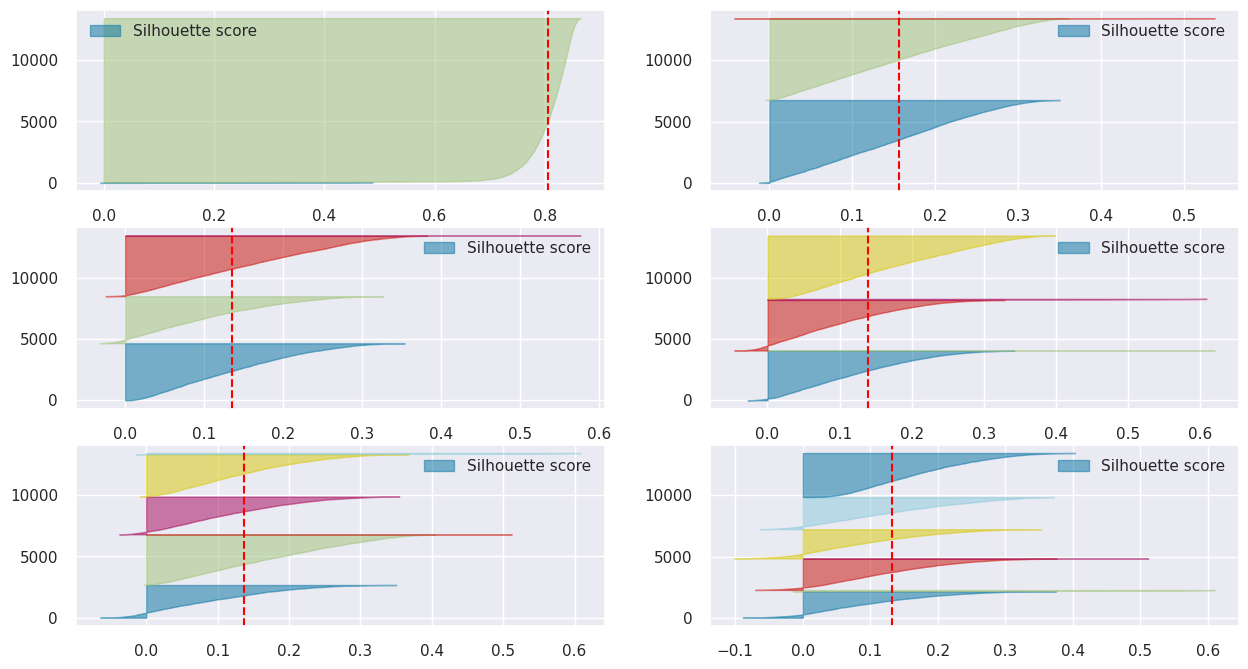

In [65]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15, 8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create K-Means instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with K-Means instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(temp_scaled)
    # Add title and legends

    visualizer.ax.legend(['Silhouette score'])

K = 5 gives us a nice uniform distribution with all clusters having above-average Silhouette scores, so let's proceed with that.

In [66]:
# Final K-Means model with k=5
kmeans = KMeans(n_clusters=5, max_iter=50, random_state=0)
kmeans.fit(temp_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=5, random_state=0)

In [67]:
# Assigning the label to data points
instacart_df['cluster_id'] = kmeans.labels_
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders,cluster_id
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.120001,4
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.270000,0
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.080000,2
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218488,16.059999,4
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538461,14.692307,13.540000,2


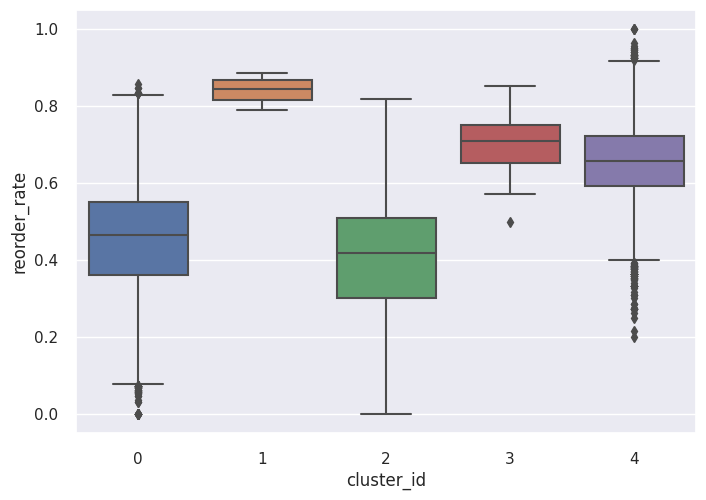

In [68]:
# As the first step, let's plot the parameter of interest (reorder_rate) with different cluster ids and see if we can find a pattern.
sns.boxplot(x='cluster_id', y='reorder_rate', data=instacart_df)
plt.show()

CLuster 1, 3 and 4 has very high re-order rates compared to 0 and 2 clusters

#### Analyzing mean values for different columns to detect patterns based on cluster formation

In [69]:
instacart_df.groupby('cluster_id').agg(
    num_products_in_cluster=('num_orders', 'count'),
    mean_num_orders=('num_orders', 'mean'),
    mean_num_reordered=('num_reordered', 'mean'),
    mean_reorder_rate=('reorder_rate', 'mean'),
    mean_add_to_cart_mean=('add_to_cart_mean', 'mean'),
    mean_order_mean_dow=('order_mean_dow', 'mean'),
    mean_order_mean_hour_of_day=('order_mean_hour_of_day', 'mean'),
    mean_mean_day_gap_in_orders=('mean_day_gap_in_orders', 'mean')
)

# [['num_orders','num_reordered','reorder_rate','add_to_cart_mean','order_mean_dow','order_mean_hour_of_day','mean_day_gap_in_orders']].mean().reset_index()
# .merge(instacart_df['cluster_id_random'].value_counts().reset_index().rename(columns = {'index':'cluster_id_random','cluster_id_random':'num_products_in_cluster'})))

,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id,,,,,,,,
0,4034,51.615022,24.343580,0.449068,9.839949,2.554951,14.006989,19.214941
1,4,13721.000000,11644.250000,0.840083,6.306344,2.608582,13.561049,16.253750
2,4114,51.086048,21.907146,0.399724,10.673822,2.936973,13.355541,16.138771
3,79,2969.670886,2116.784810,0.705388,8.203812,2.614335,13.553150,16.691809
4,5146,114.424796,75.726972,0.655618,7.754990,2.786895,13.490129,16.695818


Some observable insights based on the clusterwise data distribution are:


* Cluster **1** has the highest number of orders, along with the highest reorder rate; this group also has a very small number of products
* Cluster **3** also has a relatively high number of orders and reorder rate, but it has a small portfolio of products
* Cluster **4** has a high product count with relatively low demand and reorder rate
* Clusters **0** and **2** have the least number of orders. This is coupled with a relatively low reorder rate, although the number of products is relatively high
* Apart from 'number of products', 'total number of orders placed', and 'the reorder rate', other variables do not show significant variation for the different clusters.

#### Experimenting with other modes of Centroid Initialization


In [70]:
# By default, the K-means algorithm applies the K-means++ centroid initialization technique to the algorithm to get better initial cluster centers.
# Now, let us check what happens when we choose random cluster center initialization

kmeansrm = KMeans(n_clusters=5, max_iter=50, init='random', random_state=0)
kmeansrm.fit(temp_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(init='random', max_iter=50, n_clusters=5, random_state=0)

In random init we got number of clusters as 5

In [71]:
kmeansrm.labels_

array([1, 1, 4, ..., 3, 4, 1], dtype=int32)

In [72]:
#Taking the labels assigned after clustering for all the data points
ymeansrm = kmeansrm.labels_

In [73]:
labelsrm, countsrm = np.unique(ymeansrm, return_counts=True)

In [74]:
instacart_df['cluster_id_random'] = ymeansrm 

In [75]:
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders,cluster_id,cluster_id_random
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.120001,4,1
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.270000,0,1
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.080000,2,4
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218488,16.059999,4,1
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538461,14.692307,13.540000,2,4


In [76]:
#Printing the mean value for all the variables with random centroid initialization
(instacart_df.groupby('cluster_id_random')
.agg(num_products_in_cluster=('num_orders', 'count'),
     mean_num_orders=('num_orders', 'mean'),
     mean_num_reordered=('num_reordered', 'mean'),
     mean_reorder_rate=('reorder_rate', 'mean'),
     mean_add_to_cart_mean=('add_to_cart_mean', 'mean'),
     mean_order_mean_dow=('order_mean_dow', 'mean'),
     mean_order_mean_hour_of_day=('order_mean_hour_of_day', 'mean'),
     mean_mean_day_gap_in_orders=('mean_day_gap_in_orders', 'mean')
     ))
# [['num_orders','num_reordered','reorder_rate','add_to_cart_mean','order_mean_dow','order_mean_hour_of_day','mean_day_gap_in_orders']].mean().reset_index()
# .merge(instacart_df['cluster_id_random'].value_counts().reset_index().rename(columns = {'index':'cluster_id_random','cluster_id_random':'num_products_in_cluster'})))

,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id_random,,,,,,,,
0,3396,69.904299,36.420200,0.502167,10.763558,2.592385,13.467813,15.322876
1,4070,156.199263,105.614005,0.673796,7.419403,2.744807,13.485689,17.116117
2,28,5954.357143,4586.785714,0.740680,7.948964,2.597192,13.562623,16.504679
3,3117,49.046840,20.910812,0.407068,10.140546,2.493257,13.822398,19.471455
4,2766,37.590022,16.153651,0.416349,9.257521,3.300217,13.704415,17.481770


####**Summary**
Via the random initialization method, we observe that clusters formed have similar mean values for the variables. 

*   Cluster 2 has a very small product portfolio but a much higher order and reorder counts.  
*   Clusters 0, 3, and 4 have comparable product counts, number of orders, and reorder rates.
*   Cluster 1 has the second-highest reorder rate with a slightly elevated number of orders and a large product count.

In conclusion, both K-Means++ and Random Initialization give us valuable insights. We can try different initialization methods and then use results from the one that makes the most sense for our business case. 

Also, we can enhance this analysis by including other factors such as acquisition cost, shipping cost, weight, supply chain factors, etc., to make richer observations and use them to inform our business decisions.

####**Evaluation**:
Analysis of results of both tables using K-Means++ and random initialization methods show that other than 2 attributes, namely num_orders and reorder_rate, other remaining attribute values do not change an appreciable amount.  This suggests that they do not contribute to cluster formation quality.

For much larger datasets, computational effort to determine clusters might be significant. We can address this issue by reducing the number of attributes which we employ for the clustering algorithm.

Accordingly, we can try a simpler model to see whether reducing complexity by using smaller number of attributes helps us achieve results comparable to those obtained using a larger number of attributes.

Let us now try a more focused approach by keeping only significant variables for the algorithm, namely 'num_orders' and 'reorder_rate'

In [77]:
focussed_data = instacart_df[['num_orders', 'reorder_rate']].copy()
#Let's scale these values for our clustering algorithm, we'll call this data frame 'scaled_df1'.
scaled_df1 = scaler.fit_transform(focussed_data[['num_orders', 'reorder_rate']])

In [78]:
#Printing values after scaling
scaled_df1[:5]

array([[-0.05614028,  0.73908156],
       [-0.20094844,  0.69138824],
       [-0.22508314,  0.13374316],
       [ 0.05916992,  0.41725189],
       [-0.22508314, -0.30440686]])

####Applying K-Means on the focused dataframe
For this, we'll reapply the steps of model building:

Step 1: Finding the Optimal Number of Clusters
  1.  WCSS Method




/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

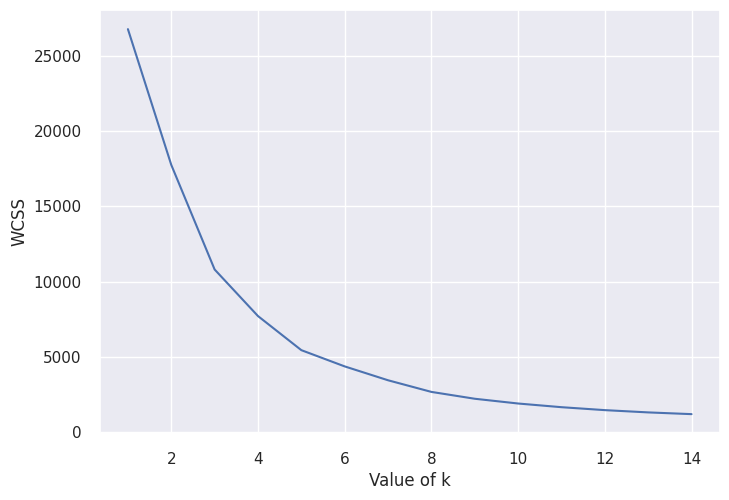

In [79]:
# elbow-curve/WCSS
ssd = []
range_n_clusters = range(1, 15)
for num_clusters in range_n_clusters:
    kmeansv2 = KMeans(n_clusters=num_clusters, max_iter=50, init='k-means++', random_state=0)
    kmeansv2.fit(scaled_df1)
    
    ssd.append(kmeansv2.inertia_)
    
# Plot the SSDs for each n_clusters
# ssd
plt.plot(range_n_clusters, ssd)
plt.xlabel("Value of k")
plt.ylabel("WCSS")
plt.show()

2.   Silhouette Score analysis method:



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

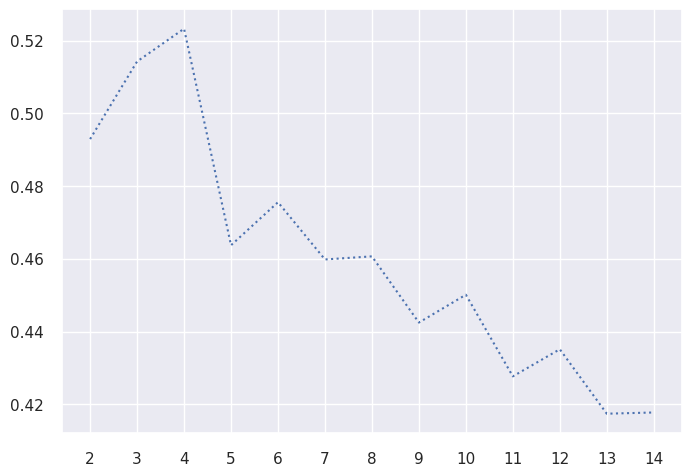

In [80]:
# silhouette analysis
range_n_clusters = range(2,15)
temp2=[]

for num_clusters in range_n_clusters:
    
    # intialise K-Means
    kmeansv2 = KMeans(n_clusters=num_clusters, max_iter=50, init='k-means++', random_state=0)
    kmeansv2.fit(scaled_df1)
    
    cluster_labels_v2 = kmeansv2.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(scaled_df1, cluster_labels_v2)
    temp2.append(silhouette_score(scaled_df1, kmeansv2.labels_))

    #print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

#Visualizing variation in the Silhouette score:
    
plt.plot(temp2, linestyle = 'dotted')
default_x_ticks = range(len(range_n_clusters))
plt.xticks(default_x_ticks, range_n_clusters)
plt.show()

From the above score is max at k = 4

In [81]:
# Final model with k=4
kmeansv2 = KMeans(n_clusters=4, max_iter=50, init='k-means++', random_state=0)
kmeansv2.fit(scaled_df1)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=50, n_clusters=4, random_state=0)

In [82]:
instacart_df['cluster_id_v2'] = kmeansv2.labels_
instacart_df.head()

,product_name,aisle_id,department_id,num_orders,num_reordered,reorder_rate,add_to_cart_mean,order_mean_dow,order_mean_hour_of_day,mean_day_gap_in_orders,cluster_id,cluster_id_random,cluster_id_v2
0,Chocolate Sandwich Cookies,61,19,76,49,0.644737,6.921052,3.026316,12.960526,17.120001,4,1,2
1,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,22,14,0.636364,8.954545,2.727273,15.272727,17.270000,0,1,2
2,Cut Russet Potatoes Steam N' Mash,116,1,13,7,0.538462,9.846154,4.538462,13.461538,15.080000,2,4,2
3,Sparkling Orange Juice & Prickly Pear Beverage,115,7,119,70,0.588235,8.285714,2.865546,14.218488,16.059999,4,1,2
4,Chocolate Fudge Layer Cake,119,1,13,6,0.461538,10.615385,3.538461,14.692307,13.540000,2,4,1


<Axes: xlabel='cluster_id_v2', ylabel='reorder_rate'>

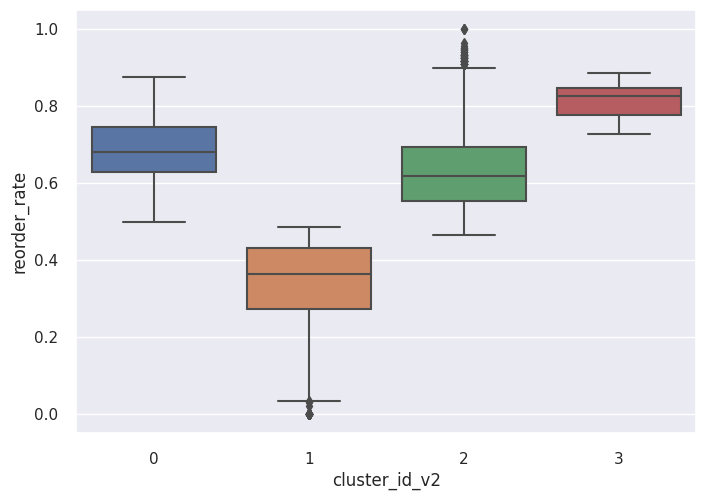

In [83]:
# Plotting the boxplot for reorder_rate for the clusters formed
sns.boxplot(x='cluster_id_v2', y='reorder_rate', data=instacart_df)

#### Let us now check the mean value of different columns with the updated cluster labels.

In [84]:
labels, counts = np.unique(kmeansv2.labels_, return_counts=True)


In [85]:
(instacart_df.groupby('cluster_id_v2')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_num_reordered = ('num_reordered','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     mean_add_to_cart_mean = ('add_to_cart_mean','mean'),
     mean_order_mean_dow = ('order_mean_dow','mean'),
     mean_order_mean_hour_of_day = ('order_mean_hour_of_day','mean'),
     mean_mean_day_gap_in_orders = ('mean_day_gap_in_orders','mean')
     ))


,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id_v2,,,,,,,,
0,123,2176.512195,1510.186992,0.687332,8.298452,2.625500,13.556734,16.793440
1,5300,42.956226,15.559057,0.338975,9.948042,2.776305,13.625200,17.573553
2,7946,90.247546,57.142210,0.629411,8.858232,2.754795,13.592312,17.099266
3,8,10526.875000,8694.250000,0.811776,6.765075,2.593823,13.559857,16.517624


#### Let us now check how the clusters look like visually

In [86]:
labels = np.unique(kmeansv2.labels_)
labels

array([0, 1, 2, 3], dtype=int32)

In [87]:
y_kmeansv2 = kmeansv2.fit_predict(scaled_df1)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [88]:
y_kmeansv2[:5]

array([2, 2, 2, 2, 1], dtype=int32)

In [89]:
X = pd.DataFrame(scaled_df1)


In [90]:
kmeansv2.cluster_centers_

array([[ 5.57666180e+00,  9.81702700e-01],
       [-1.44751543e-01, -1.00252166e+00],
       [-1.79335968e-02,  6.51785953e-01],
       [ 2.79692673e+01,  1.69052605e+00]])

The kmeansv2.cluster_centers_ attribute contains the coordinates or values of these centroids in the feature space of the input data.

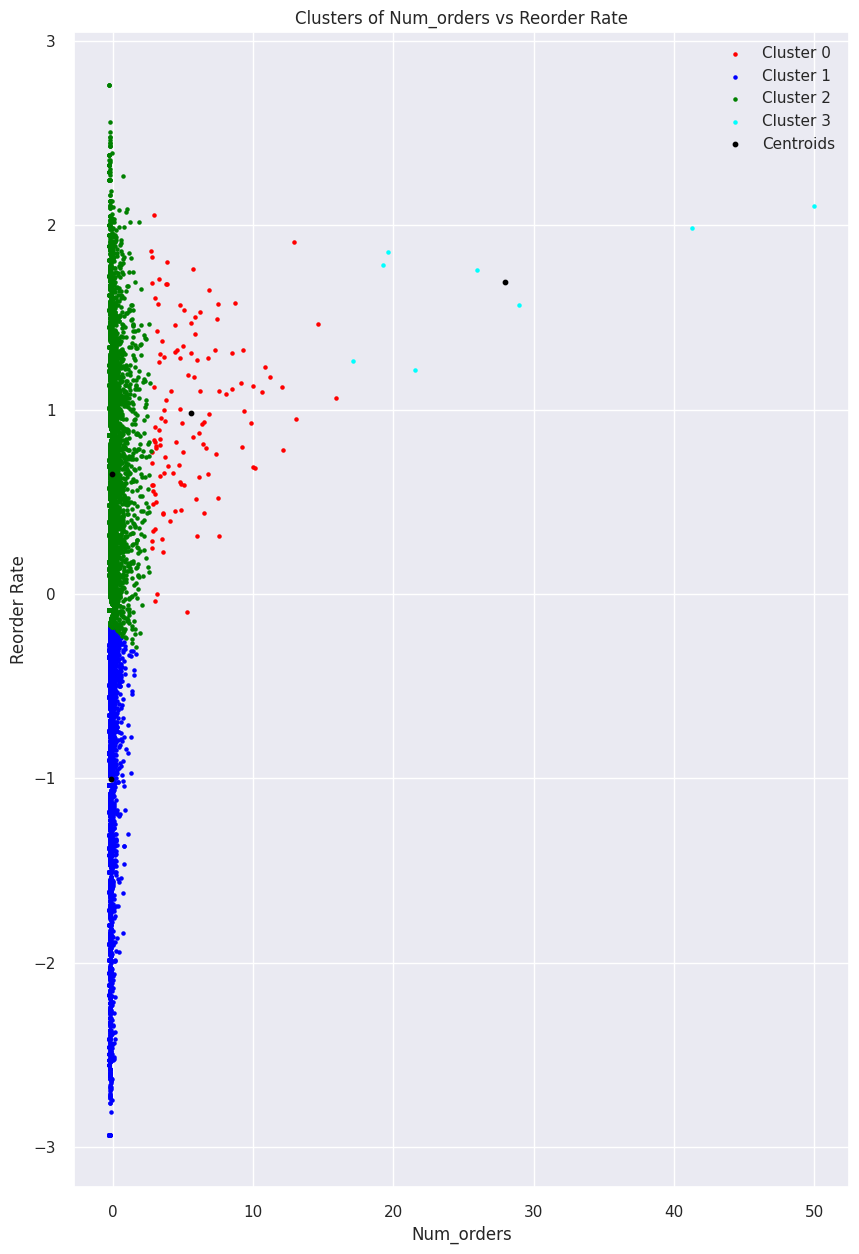

In [91]:
plt.figure(figsize =(10, 15))

plt.scatter(X[kmeansv2.labels_== 0][0], X[kmeansv2.labels_== 0][1], s=5, c='red', label ='Cluster 0')
plt.scatter(X[kmeansv2.labels_== 1][0], X[kmeansv2.labels_== 1][1], s=5, c='blue', label ='Cluster 1')
plt.scatter(X[kmeansv2.labels_== 2][0], X[kmeansv2.labels_== 2][1], s=5, c='green', label ='Cluster 2')
plt.scatter(X[kmeansv2.labels_== 3][0], X[kmeansv2.labels_== 3][1], s=5, c='cyan', label ='Cluster 3')

plt.scatter(kmeansv2.cluster_centers_[:, 0], kmeansv2.cluster_centers_[:, 1], s=10, c='black', label = 'Centroids')
plt.title('Clusters of Num_orders vs Reorder Rate')
plt.xlabel('Num_orders')
plt.ylabel('Reorder Rate')
plt.legend()
plt.show()


Summarizing the results we got via the K-Means algorithm: 

In [92]:
#Printed again for reference
(instacart_df.groupby('cluster_id_v2')
.agg(num_products_in_cluster = ('num_orders','count'),
     mean_num_orders = ('num_orders','mean'),
     mean_num_reordered = ('num_reordered','mean'),
     mean_reorder_rate = ('reorder_rate','mean'),
     mean_add_to_cart_mean = ('add_to_cart_mean','mean'),
     mean_order_mean_dow = ('order_mean_dow','mean'),
     mean_order_mean_hour_of_day = ('order_mean_hour_of_day','mean'),
     mean_mean_day_gap_in_orders = ('mean_day_gap_in_orders','mean')
     ))


,num_products_in_cluster,mean_num_orders,mean_num_reordered,mean_reorder_rate,mean_add_to_cart_mean,mean_order_mean_dow,mean_order_mean_hour_of_day,mean_mean_day_gap_in_orders
cluster_id_v2,,,,,,,,
0,123,2176.512195,1510.186992,0.687332,8.298452,2.625500,13.556734,16.793440
1,5300,42.956226,15.559057,0.338975,9.948042,2.776305,13.625200,17.573553
2,7946,90.247546,57.142210,0.629411,8.858232,2.754795,13.592312,17.099266
3,8,10526.875000,8694.250000,0.811776,6.765075,2.593823,13.559857,16.517624


We have four different clusters in our simpler Kmeans clustering model, each with notably different reorder rates and the number of products with the cluster.
* There are 8 products within (***cluster 3***) that only get reordered 81% of the time.
*Another cluster (***cluster 0***) with 123 products getting a high reorder rate of 68%.
*Again, we have a midrange demand group (***cluster 2***) with 7946 products that get repeat orders 62% of the time 
*Finally a underperforming group ( ***cluster 1***) that gets only 33% reorders

Also, notice that even after reducing the model to just 2 clusters, we could still create meaningful clusters that give us useful insights into the data. Hence, this model gives us the insights needed with the advantage of significantly reduced model complexity.

This information might help Instacart formulate more useful product clusters for customer segmentation and market basket analysis.



---

